In [1]:
# STEP 1 Load Data from PostgreSQL

In [2]:
# Import required libraries for database connection and data handling

import psycopg2
import pandas as pd
from sqlalchemy import create_engine

In [3]:
# Define PostgreSQL connection details

host = 'localhost'
database = 'PWC Customer Churn'
user = 'postgres'
password = 'admin123'
port = '5432'

In [4]:
# Connect to PostgreSQL

conn = psycopg2.connect(
    host = host,
    database = database,
    user = user,
    password = password,
    port = port
)

In [5]:
# Create a SQLALchemy engine for easier queries

engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}')

In [6]:
# Load the customer churn data into a Pandas DataFrame

customer_churn = pd.read_sql('''
    SELECT customerid, churn, contract, tenure, monthlycharges, numtechtickets,
           CASE WHEN internetservice = 'Internet Service - Fiber Optic' THEN 1 ELSE 0 END AS fiber_optic,
           CASE WHEN streamingtv = 'Streaming TV' THEN 1 ELSE 0 END AS streaming_tv,
           CASE WHEN streamingmovies = 'Streaming Movies' THEN 1 ELSE 0 END AS streaming_movies,
           CASE WHEN multiplelines = 'Multiple Lines' THEN 1 ELSE 0 END AS multiple_lines,
           CASE WHEN phoneservice = 'Phone Service' THEN 1 ELSE 0 END AS phone_service
    FROM customer_churn;
''', engine)

In [7]:
customer_churn.head(10)

,customerid,churn,contract,tenure,monthlycharges,numtechtickets,fiber_optic,streaming_tv,streaming_movies,multiple_lines,phone_service
0,3668-QPYBK,Yes,Month-to-month,2,53.85,0,0,0,0,0,1
1,7795-CFOCW,No,One year,45,42.30,3,0,0,0,0,0
2,9237-HQITU,Yes,Month-to-month,2,70.70,0,1,0,0,0,1
3,9305-CDSKC,Yes,Month-to-month,8,99.65,0,1,1,1,1,1
4,1452-KIOVK,No,Month-to-month,22,89.10,0,1,1,0,1,1
5,6713-OKOMC,No,Month-to-month,10,29.75,0,0,0,0,0,0
6,7892-POOKP,Yes,Month-to-month,28,104.80,2,1,1,1,1,1
7,6388-TABGU,No,One year,62,56.15,0,0,0,0,0,1
8,9763-GRSKD,No,Month-to-month,13,49.95,0,0,0,0,0,1
9,7469-LKBCI,No,Two year,16,18.95,0,0,0,0,0,1


In [8]:
# STEP 2 Data Preprocessing

In [9]:
# Import LabelEncoder for encoding categorical variables 

from sklearn.preprocessing import LabelEncoder

In [10]:
# Convert 'churn' columns to binary

customer_churn['churn'] = customer_churn['churn'].map({'Yes':1, 'No':0})

In [11]:
# Convert 'contract' columns into dummy variables (One-hot encoding)

customer_churn = pd.get_dummies(customer_churn, columns=['contract'], drop_first=False)

In [12]:
# Drop 'contract_Month-to-month' to avoid dummy variable trap

customer_churn.drop(columns=['contract_Month-to-month'], inplace=True)

In [13]:
customer_churn.head()

,customerid,churn,tenure,monthlycharges,numtechtickets,fiber_optic,streaming_tv,streaming_movies,multiple_lines,phone_service,contract_One year,contract_Two year
0,3668-QPYBK,1,2,53.85,0,0,0,0,0,1,False,False
1,7795-CFOCW,0,45,42.30,3,0,0,0,0,0,True,False
2,9237-HQITU,1,2,70.70,0,1,0,0,0,1,False,False
3,9305-CDSKC,1,8,99.65,0,1,1,1,1,1,False,False
4,1452-KIOVK,0,22,89.10,0,1,1,0,1,1,False,False


In [14]:
# STEP 3 Define X (Features) & Y (Target)

In [15]:
# Define feature variables (X) and target variable (y)

# Define feature variables (X) including services
X = customer_churn[['contract_One year', 'contract_Two year', 'tenure', 'monthlycharges', 'numtechtickets',
        'fiber_optic', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'phone_service']]
y = customer_churn['churn']

In [16]:
# STEP 4 Train-Test Split

In [17]:
# Import train_test_split for dataset splitting

from sklearn.model_selection import train_test_split

In [18]:
# Split dataset into training and testing sets (80% trainin, 20% testing)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training samples: {len(X_train)}, Testing samples: {len(X_test)}')

Training samples: 5634, Testing samples: 1409


In [19]:
# STEP 5 Train Logistic Regression

In [20]:
# Import LogisticRegression for classification

from sklearn.linear_model import LogisticRegression

In [21]:
# Initialize and train Logistic Regression model
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

In [22]:
# STEP 6 Evaluate Model Performance

In [23]:
# Import metrics for model evaluation

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

In [24]:
# Predict on test data

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1] # Get churn probabilities

In [26]:
# Print classification reports 

print('Model Performance:')
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Performance:
Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1057
           1       0.56      0.91      0.69       352

    accuracy                           0.80      1409
   macro avg       0.76      0.84      0.77      1409
weighted avg       0.86      0.80      0.81      1409



In [27]:
# Compute AUC-ROC

auc = roc_auc_score(y_test, y_pred_prob)
print("\nAUC-ROC Performance:")
print(f"AUC-ROC Score: {auc:.4f}")


AUC-ROC Performance:
AUC-ROC Score: 0.9207


In [28]:
# STEP 7 Assign Churn Risk Scores to Customers

In [29]:
# Calculate churn risk scores (%) for all customers (active and churned)

customer_churn['Churn_Risk_scores'] = model.predict_proba(X)[:, 1] * 100

In [30]:
# Filter only customer (churn = 0)

active_customers = customer_churn[customer_churn['churn'] == 0].copy()
active_customers['Churn_Risk_Scores'] = model.predict_proba(active_customers[X.columns])[:, 1] * 100

In [31]:
# Show top 50 active customers with highest churn risk

active_customers[['customerid', 'Churn_Risk_Scores']].sort_values(by='Churn_Risk_Scores', ascending=False).head(50)

,customerid,Churn_Risk_Scores
4333,2674-MLXMN,98.942890
1165,5334-JLAXU,98.530747
4762,4001-TSBTV,98.153142
2048,2038-LLMLM,97.671342
4687,2988-GBIVW,96.736601
2163,2931-VUVJN,96.669266
1773,3144-KMTWZ,96.541129
2403,5197-PYEPU,96.160348
4361,0537-QYZZN,95.880110
6408,5298-GSTLM,95.213782


In [32]:
# STEP 8 Churn Risk Scores on Chart

In [33]:
# Import Matplotlib for data visualization  

import matplotlib.pyplot as plt

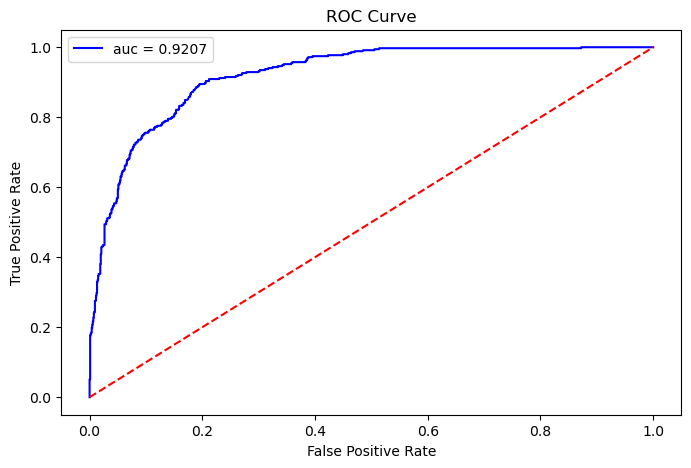

In [34]:
# Plot ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'auc = {auc:.4f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Random model reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

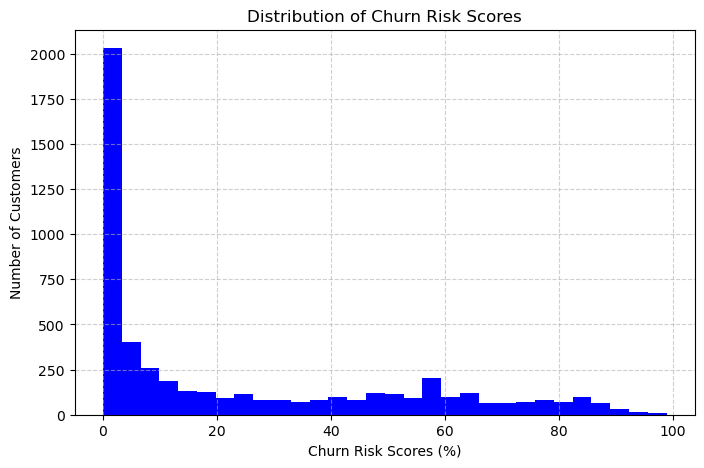

In [35]:
# Visualize churn risk distribution

plt.figure(figsize=(8,5))
plt.hist(active_customers['Churn_Risk_Scores'], bins=30, color='blue')
plt.xlabel('Churn Risk Scores (%)')
plt.ylabel('Number of Customers')
plt.title('Distribution of Churn Risk Scores')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [36]:
# Identify high-risk customers

potential_churners = active_customers[active_customers['Churn_Risk_Scores'] > 50]

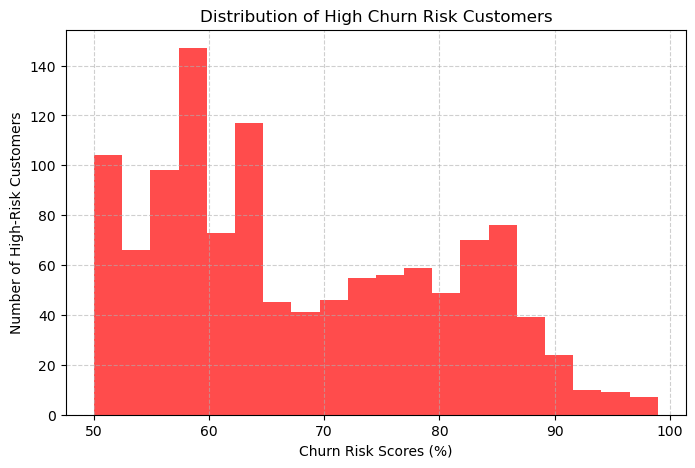

In [37]:
# Visualize high-risk customer distribution

plt.figure(figsize=(8,5))
plt.hist(potential_churners['Churn_Risk_Scores'], bins=20, color='red', alpha=0.7)
plt.xlabel('Churn Risk Scores (%)')
plt.ylabel('Number of High-Risk Customers')
plt.title('Distribution of High Churn Risk Customers')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [38]:
# STEP 9 Churn Risk Estimation

In [39]:
# Summary statistics

print(f"Total Active Customers: {len(active_customers)}")
print(f"Potential Churners: {len(potential_churners)}")
print(f"Churn Risk Percentage: {(len(potential_churners) / len(active_customers)) * 100:.2f}%")

Total Active Customers: 5174
Potential Churners: 1191
Churn Risk Percentage: 23.02%
